## BERT Classifier using ktrain package

In [1]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

#### Check for GPU presence

In [2]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Sat May 20 17:41:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.__version__

'2.12.0'

In [ ]:
#!pip install ktrain --upgrade

In [4]:
# import ktrain
import ktrain
from ktrain import text

#### Check available text classifiers in ktrain

In [5]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


### Load Data

In [8]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_pickle(io.BytesIO(uploaded["data_final.pkl"]))

Saving data_final.pkl to data_final.pkl


In [12]:
# filter only to house bills and senate bills
df = df[(df['BillType'] == 'hr') | (df['BillType'] == 's')]
df.shape

(18907, 94)

In [13]:
df.head(5)

,cbo_estimate_url,senate_passage,govtrack_url,PLaw,subcommittee_codes,sponsor_id,house_passage_vote,NameFirst,NameLast,congress,...,votes,short_title,Major,Delegate,ImpBill,gpo_pdf_uri,Party,NameFull,Minor,Veto
85,None,None,https://www.govtrack.us/congress/bills/113/hr11,0,"[HSED13, HSED14, HSJU08, HSII24, HSIF14]",M001160,None,Gwen,Moore,113,...,[],Violence Against Women Reauthorization Act of ...,20.0,0,1.0,None,100.0,Gwen Moore,2011.0,0
86,None,None,https://www.govtrack.us/congress/bills/113/hr12,0,"[HSED13, HSJU10, HSVR03, HSSY15]",L000287,None,John,Lewis,113,...,[],Voter Empowerment Act of 2013,2.0,0,1.0,None,100.0,John Lewis,206.0,0
87,https://www.cbo.gov/publication/45206,None,https://www.govtrack.us/congress/bills/113/hr15,0,"[HSSY15, HSHM11, HSII22, HSII10, HSIF17]",G000573,None,Joe,Garcia,113,...,[],"Border Security, Economic Opportunity, and Imm...",9.0,0,1.0,None,100.0,Joe Garcia,900.0,0
88,None,None,https://www.govtrack.us/congress/bills/113/hr20,0,[HSIF16],S001168,None,John,Sarbanes,113,...,[],Government By the People Act of 2014,20.0,0,1.0,None,100.0,John Sarbanes,2012.0,0
89,None,None,https://www.govtrack.us/congress/bills/113/hr21,0,[HSJU08],M000933,None,James,Moran,113,...,[],NRA Members' Gun Safety Act of 2013,12.0,0,1.0,None,100.0,James Moran,1209.0,0


### Prepare source data

In [14]:
#creating the target cariable
df['target_class'] = (df['PassH'] == 1) | (df['PassS'] == 1)

## STEP 1:  Load and Preprocess the Dataset


In [15]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
nGramRange = 1 #size of multi-word phrases to consider
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.3 #Proportion of training to use for validation

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = df, 
                                                                    text_column  = 'summary', 
                                                                    label_columns = ['target_class'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)

['not_target_class', 'target_class']
       not_target_class  target_class
13850               0.0           1.0
12209               1.0           0.0
439                 1.0           0.0
11837               1.0           0.0
15209               1.0           0.0
['not_target_class', 'target_class']
       not_target_class  target_class
17468               1.0           0.0
8337                1.0           0.0
2785                1.0           0.0
15755               1.0           0.0
2905                1.0           0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## STEP 2:  Load a pretrained BERT model and wrap it in a `ktrain.Learner` object

In [16]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 200


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [17]:
batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)

## STEP 3: Train the Model


In [18]:
# briefly simulate training to find good learning rate

learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
828/828 [==============================] - 637s 740ms/step - loss: 0.2383 - accuracy: 0.9243
Epoch 2/3
828/828 [==============================] - 613s 741ms/step - loss: 0.5063 - accuracy: 0.9052
Epoch 3/3
828/828 [==============================] - 5s 5ms/step - loss: 2.4538 - accuracy: 0.7857


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


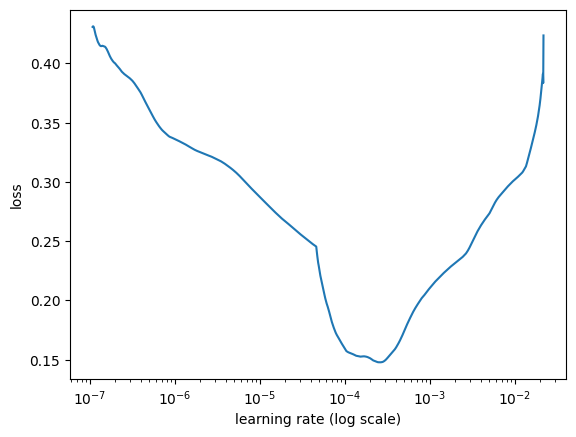

In [19]:
learner.lr_plot()

In [20]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
828/828 [==============================] - 787s 924ms/step - loss: 0.1430 - accuracy: 0.9442 - val_loss: 0.0973 - val_accuracy: 0.9614
Epoch 2/3
828/828 [==============================] - 759s 917ms/step - loss: 0.1029 - accuracy: 0.9571 - val_loss: 0.0935 - val_accuracy: 0.9637
Epoch 3/3
828/828 [==============================] - 760s 918ms/step - loss: 0.0933 - accuracy: 0.9612 - val_loss: 0.0946 - val_accuracy: 0.9603


We can use the `learner.validate` method to test our model against the validation set.

In [21]:
learner.validate(val_data=(x_test, y_test))

178/178 [==============================] - 93s 497ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5151
           1       0.75      0.86      0.80       522

    accuracy                           0.96      5673
   macro avg       0.87      0.92      0.89      5673
weighted avg       0.96      0.96      0.96      5673



array([[4998,  153],
       [  72,  450]])

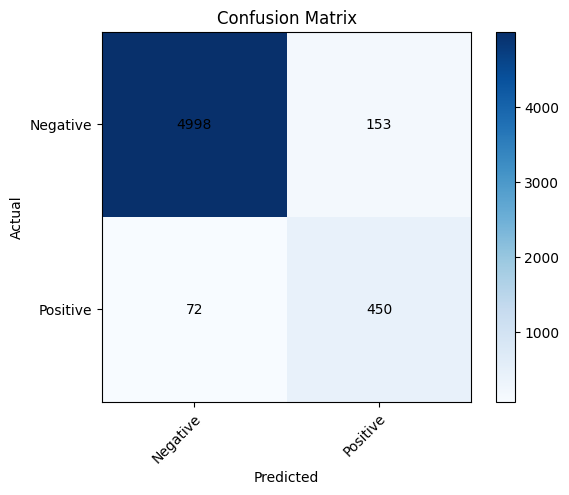

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Given confusion matrix
cm = np.array([[4998,  153],
       [72,  450]])

# Define class labels
labels = ['Negative', 'Positive']

# Create heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()